# Imports

In [1]:
import pickle

import numpy as np
import seaborn as sns
from fluxes import power_law
from scipy.interpolate import RegularGridInterpolator
from tools import get_mids
from settings import *

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


## Get background flux
The atmospheric background flux is calculated in core/atmospheric_background.py with MCEq

In [2]:
# %run ../../core/atmospheric_background.py
## run this only if you want to update the MCEq flux file

# Load data

In [3]:
# set up binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

In [4]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(bckg_flux["numu_conv"])
)
# baseline evaluation grid
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi((em, ss)))

# Show the background spectrum

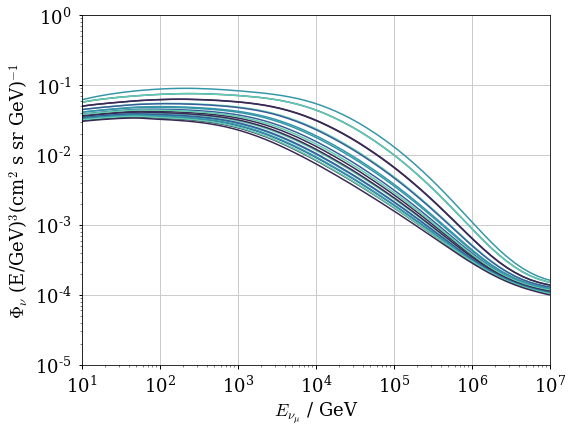

In [5]:
spec = 3
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    for i, (pref, lab) in enumerate([('numu_', r'\nu_\mu')]):

        p0 = ax.loglog(
            e_grid,
            e_grid**(spec)*bckg_flux[pref + 'total'][:,ti],
            ls='solid',
            lw=1.5,
        )
    
ax.set_xlim(10,1e7)
ax.set_ylim(1e-5,1)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) +" }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()

## with astro flux as comparison

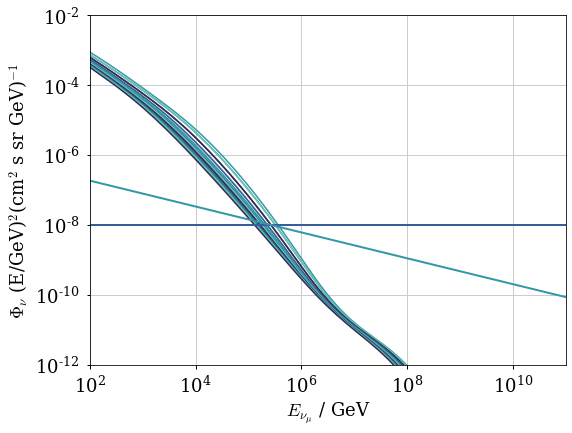

In [6]:
spec = 2
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):
        p0 = ax.loglog(
            e_grid,
            e_grid ** (spec) * bckg_flux[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )
ax.loglog(
    e_grid, power_law(e_grid, 1e5, 2, 1e-18) * e_grid ** (spec)
)  # generic spectrum ~ WB
ax.loglog(
    e_grid, power_law(e_grid, 1e5, GAMMA_ASTRO, PHI_ASTRO) * e_grid ** (spec)
)  # best-fit numu
ax.set_xlim(1E2, 1e11)
ax.set_ylim(1e-12, 1e-2)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


## check event numbers with effective areas

In [7]:
from aeff_calculations import get_aeff_and_binnings

In [8]:
aeff_2d, log_ebins, ebins, sindec_bins, _ = get_aeff_and_binnings("full")
log_emids = get_mids(log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

40 log_10(energy) bins
50 declination bins


In [9]:
# with two dimensions: sindec, energy
aeff_eval_e_sd = lambda aeff: (aeff * sindec_width).T * ewidth * 2*np.pi

In [10]:
# check
for det in ["IceCube", "Plenum-1"]:
    aeff_factor = aeff_eval_e_sd(aeff_2d[det]) * LIVETIME
    astro_ev = aeff_factor * (emids/E_NORM)**(-GAMMA_ASTRO) * PHI_ASTRO
    atm_ev = aeff_factor * spl_vals

    print(det)
    print("conv events:", np.sum(atm_ev))
    print("astro events:", np.sum(astro_ev))

IceCube
conv events: 606760.3861226646
astro events: 2670.825720075005
Plenum-1
conv events: 2443911.8591510537
astro events: 10674.339764681874
